<a href="https://colab.research.google.com/github/o-fugi/FURSPColexification/blob/main/code/Gaussian_Mixture_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/ColabFiles/

Mounted at /content/drive/
/content/drive/MyDrive/ColabFiles


In [2]:
import pandas as pd
import re
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from functools import reduce
import matplotlib as mpl
import torch

In [11]:
# install sentence-trasnformers
# %%capture
! pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
model = SentenceTransformer('whaleloops/phrase-bert')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/670 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/632 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [4]:
shift_class_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/cleaned_classified_df.csv', encoding='ISO-8859-1')

In [5]:
# remove NaN rows
shift_class_df['Bleached sense'] = shift_class_df['Bleached sense'].fillna('NaN')
shift_class_df = shift_class_df[shift_class_df['Bleached sense']!='NaN']

# remove completely duplicated rows
shift_class_df = shift_class_df[~shift_class_df.duplicated()]

# these seem a little outside of our area of study 
# shift_class_df = shift_class_df[shift_class_df['Type of change']!= 'grammaticalization']
# shift_class_df = shift_class_df[shift_class_df['Type of change']!= 'synaesthesia']

allowed_types = ['metaphor', 'narrowing', 'pejoration', 'broadening', 'metonymy', 'amelioration', 'antonymy', 'analogy', 'broadening, metaphor', 'pejoration, homophony']
shift_class_df = shift_class_df[shift_class_df['Type of change'].isin(allowed_types)]

shift_class_df = shift_class_df.reset_index()

In [6]:
# get rid of punctuation in the senses

def cleanString(s):
  s = s.lower()
  s = s.replace("'", "")
  s = s.replace(",", "")
  s = s.replace(";", "")
  s = s.lower()
  return s

shift_class_df['meaning1'] = shift_class_df['meaning1'].apply(cleanString)
shift_class_df['meaning2'] = shift_class_df['meaning2'].apply(cleanString)

In [206]:
# work with datsemshift instead

sem_shift_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/cleaned_dat_sem_shift.csv')

sem_shift_df['meaning1'] = sem_shift_df['meaning1_clean']
sem_shift_df['meaning2'] = sem_shift_df['meaning2_clean']

sem_shift_df = sem_shift_df.drop([697, 1521])

shift_class_df = sem_shift_df[sem_shift_df['realizations'] > 1]

shift_class_df = shift_class_df.reset_index()

In [207]:
# dictionary for concreteness and embeddings
vec_dic = {} # This will be a dictionary that easily allows us to access the embedding for all of our senses, saving time. 
error_senses = set()  # This represents the set of senses for which there was a problem converting them to embeddings or concreteness values

for i in range(len(shift_class_df)): # Here we loop through each row of our dataframe, and if we can convert a sense s to an embedding then we set vec_dic[s] = embedding
  row = shift_class_df.iloc[i]
  x = row["meaning1"]
  y = row["meaning2"]

  try:   
    if x not in vec_dic:
      xvec = np.array(model.encode(x))
      vec_dic[x] = xvec
  except:
    error_senses.add(x)

  try:  
    if y not in vec_dic:
      yvec = np.array(model.encode(y))
      vec_dic[y] = yvec
  except: 
    error_senses.add(y)

error_senses = list(error_senses) # List of all senses that could not be converted to embeddings. Should be empty right now with phrase BERT
senses = list(vec_dic.keys()) # List of all concepts

sense_indices = {senses[i]:i for i in range(len(senses))} # sense_indices is a dictionary where its keys are senses and its values are the indices for which the senses appear in our list of senses.

In [208]:
# create dataframe with a pair of embeddings for each shift

all_vars_df = pd.DataFrame()
all_vars_df['meaning1'] = shift_class_df['meaning1']
all_vars_df['meaning2'] = shift_class_df['meaning2']

# #if working with the English database, these are helpful
# all_vars_df['word'] = shift_class_df['Word']
# all_vars_df['type'] = shift_class_df['Type of change']

# all_vars_df['concat_meaning1'] = all_vars_df['word'] + " " + all_vars_df['meaning1']
# all_vars_df['concat_meaning2'] = all_vars_df['word'] + " " + all_vars_df['meaning2']

vec_df = pd.DataFrame.from_dict(vec_dic, orient='index').reset_index().rename(columns={'index':'Word'})
vec_meaning_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [all_vars_df, vec_df])
vec_meaning_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [vec_meaning_df, vec_df])
vec_meaning_df = vec_meaning_df.drop(['Word_x', 'Word_y'], axis=1)

In [209]:
# create dataframe with one difference embedding for each shift

vec_diff_df = pd.DataFrame()

for i in range(len(model.encode('yikes'))):
  vec_diff_df[i] = vec_meaning_df[str(i) + "_y"] - vec_meaning_df[str(i) + "_x"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [210]:
# source vector and difference vector should capture most data

# source_shift_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [all_vars_df, vec_df])
# source_shift_df = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True, how='left'), [source_shift_df, vec_diff_df])

# i just want to do difference data, actually. 

source_shift_df = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True, how='left'), [all_vars_df, vec_diff_df])

In [248]:
# pca, just so the gaussian mixture will perform a little better
# x = source_shift_df.drop(['word', 'meaning1', 'meaning2', 'type'], axis=1).values # if working with English database
x = source_shift_df.drop(['meaning1', 'meaning2'], axis=1).values
scaler = StandardScaler()
scaler.fit(x)
x_scale = scaler.transform(x)

# do PCA
pca = PCA(n_components=50)
pca.fit(x_scale)
components = pca.transform(x_scale)
components_df = pd.DataFrame(data = components)#.rename(columns={0:'PC_1' , 1:'PC_2', 2:"PC_3", 3:'PC_4'})

# merge back into word data
df = reduce(lambda  left,right: pd.merge(left,right, left_index=True, right_index=True), [all_vars_df, components_df])

some notes on diff + source

seems like 0 is animate -> inanimate when the coefficient is low, but when the coefficient is high, the pattern is unclear. it's mostly shifts between verbs

seems like 1 has a general concrete -> abstract pattern when the coefficient is low, but again, when the coefficient is high, the pattern is more unclear.

notes on diff

seems like 0 is person -> not person when coefficient is high and not person -> person when coefficient is low? by "person", either titles of people (father, wife) or characteristics of people (drunk, to feel pity, blind, forehead). 

seems like 1 is animate -> inanimate when coefficient is high and inanimate -> animate when coefficient is low

*also explains variance a lot faster than diff + source*

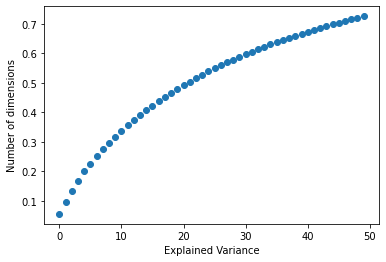

In [212]:
# check explained variance

plt.xlabel("Explained Variance")
plt.ylabel("Number of dimensions")
plt.scatter(range(50), np.cumsum(pca.explained_variance_ratio_))

## GMM

### 2d / scatterplot

In [220]:
n_components = 30
estimator = GaussianMixture(n_components=n_components, covariance_type='full', max_iter=20, random_state=0) # other covariance is "spherical", "diag", "tied"
estimator.fit(df[[0, 1]])

GaussianMixture(max_iter=20, n_components=30, random_state=0)

In [23]:
el_colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'cyan', 'grey', 'coral', 'pink']

def make_ellipses(gmm, ax):
    for n, color in enumerate(el_colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], 180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")

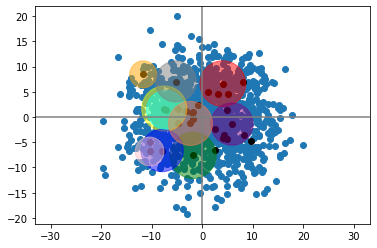

<Figure size 720x720 with 0 Axes>

In [273]:
fig, ax = plt.subplots()

plt.figure(figsize=(10, 10))

# colors 
allowed_types = ['metaphor', 'narrowing', 'pejoration', 'broadening', 'metonymy', 'amelioration', 'antonymy', 'analogy', 'broadening, metaphor', 'pejoration, homophony']
colors = {'metaphor':'maroon', 'metonymy': 'red', 'analogy': 'pink','antonymy': 'pink','narrowing':'blue', 'pejoration':'green', 'broadening':'purple', 'amelioration': 'orange', 'broadening, metaphor': 'red', 'pejoration, homophony':'green'}
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
#ax.legend(markers, colors.keys(), numpoints=1)

ax.axhline(y=0, color='grey')
ax.axvline(x=0, color='grey')

# plt.title("PCA on difference scatterplot")
# plt.xlabel("Dimension 0")
# plt.ylabel("Dimension 1")

ax.scatter(df[0], df[1])# , c=df.type.map(colors))
ax.scatter(estimator.means_[:,0], estimator.means_[:,1], c='black')

make_ellipses(estimator, ax)

### 50d

In [249]:
# group the shifts

n_dimensions = 50
n_components = 30
estimator = GaussianMixture(n_components=n_components, covariance_type='spherical', init_params='kmeans', max_iter=20) # other covariance is "spherical", "diag", "tied"
estimator.fit(df[range(n_dimensions)])

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


GaussianMixture(covariance_type='spherical', max_iter=20, n_components=30)

In [250]:
# theoretically, the estimator.means_ should give us some prototypical shift types
# how to interpret these... maybe look at the shifts that fall closest to each of these means?  

# distance + cosine similarity from the means
for n in range(len(estimator.means_)):
  df['dist_' + str(n)] = np.linalg.norm(df[range(n_dimensions)] - estimator.means_[n], axis=1)
  df['sim_' + str(n)] = util.cos_sim(np.asarray(df[range(n_dimensions)]), toTensor(estimator.means_[n]))

# gmm gives a probability estimator, but it's kind of crap, and often gives 1.0 and 0.0
prob_df = pd.DataFrame(estimator.predict_proba(np.asarray(df[range(n_dimensions)])))
prob_df.columns = ['prob_'+str(i) for i in range(len(estimator.means_))]

# they also label points by probability -- not really what we want, but interesting
label_df = pd.DataFrame(estimator.predict(np.asarray(df[range(n_dimensions)])))
label_df = label_df.rename(columns={0:'label'})

df = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True, how='left'), [df, prob_df])
df = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True, how='left'), [df, label_df])

# when working with datsemshift ...
# all of the means are pretty much the same -- close to 0. so the shifts that fall closest to these means are the ones that barely shift at all
# e.g. Mercury -> mercury, free -> free of charge, frog -> toad, etc
# so i should maybe look at alternative methods of finding those means, or alternative covariance types? 
# no, doesn't really work. i guess the issue is the distribution of data itself. is it really just random?
# just because there's meaning along each of the axes doesn't necessarily mean that there exists any clustering along those axes
# okay! increased the number of clusters (to 30 from 6) and then looked for the estimator mean that's the farthest away from the origin
# that was estimator 5 (whatever), but it so happens to have a super clear pattern of body parts -> river-related formations. 
# estimator 17 was body parts -> mountain formations
# everything else is totally useless. all too close to the origin to have any more information than "shifts that don't move much" 
# tried increasing the number of clusters to 50, because whatever
# now we have a cluster for source -> suits of cards, a small cluster for source -> compass directions
# if we set covariance_type = spherical, we get a couple more clear clusters. target is marraige-themed, for example. source is family members
# it's just weird, though. we can get some helpful clumps that mean things, but what now? 

# when working with the english database ... 
# some clearer patterns emerge. although, it might just be a facet of the dataset
# estimator 0 catches the animal -> person shifts
# estimator 1 has a lot of body part -> target shifts
# estimator 2 definitely looks like it's surrounded by pejorative shifts
# but now we're back with the same problem as before .. how do we categorize these smartly? 

# i guess the overall takeaway is that we need to do the same thing that raymond and oliver are doing right now -- categorize the clusters
# my method of doing this is bad. or, possibly, the clustering is bad.
# since half of the clusters have a 0% chance of ANY shift being an element of those clusters
# and those are the ones farther from the origin, and those are the ones with better-defined patterns
# my goal for tomorrow is to fix that, i guess ... ?

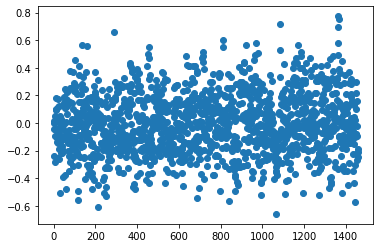

In [251]:
# also, the plot of distances from the means is generally an s-shape (english + datsemshift)

n=5
# plt.scatter(range(len(df)), df.sort_values(by=('prob_' + str(n)))['prob_' + str(n)])
plt.scatter(range(len(df)), df['sim_' + str(n)])

In [252]:
# sort by likelihood of being in that group

n=2
df[['meaning1', 'meaning2', ('prob_' + str(n)), 'label', ('dist_' + str(n)), ('sim_' + str(n))]].sort_values(by=('sim_' + str(n)), ascending=False).head(20)

,meaning1,meaning2,prob_2,label,dist_2,sim_2
611,nose,cape,9.998040e-01,2,17.045289,0.720453
613,nose,front part,9.999882e-01,2,18.279743,0.707920
865,throat,ravine,1.171742e-03,9,17.010651,0.706018
389,head,side,9.999968e-01,2,17.258664,0.694404
307,forehead,front part,9.999711e-01,2,17.913422,0.692939
497,lip,edge,9.970203e-01,2,14.761566,0.691185
569,mouth,edge,9.999991e-01,2,18.798027,0.677513
258,face,direction,9.999964e-01,2,21.114304,0.667721
259,face,front part,9.998238e-01,2,22.047392,0.658067
575,mouth,ravine,9.999929e-01,2,21.892707,0.654960


In [319]:
# use the label given by the model

n=14
print(source_words[n])
print(target_words[n])
df[['meaning1', 'meaning2', ('prob_' + str(n)), ('dist_' + str(n))]][df['label']==n]

['bodily', 'parental', 'abdominal', 'committed', 'disciplinary']
['inland', 'coastal', 'rural', 'steep', 'outdoor']


,meaning1,meaning2,prob_14,dist_14
30,back body part,mountain ridge or edge,1.0,15.283925
125,cheek,mountain slope,1.0,11.711262
127,chest body part,mountain slope,1.0,14.052654
261,face,mountain slope,1.0,18.037896
292,flank body part,mountain slope,1.0,15.577727
299,foot,mountain foot,1.0,13.249406
308,forehead,mountain slope,1.0,11.939166
424,horn,peak of mountain,1.0,17.565088
521,mane,mountain ridge or edge,1.0,19.049147
600,neck,mountain pass,1.0,11.917365


In [259]:
# which ones are farthest from the origin? unfortunately, after some distance from the origin, nothing gets labelled as likely to be in that cluster 

np.argsort([np.linalg.norm(estimator.means_[i]) for i in range(len(estimator.means_))])

array([16, 25, 13, 11, 21,  6,  3,  5, 27, 15,  4,  8, 12, 17,  2, 28, 20,
        7, 23,  0, 29, 22, 19, 26, 10, 24, 18,  9,  1, 14])

### how many clusters? 

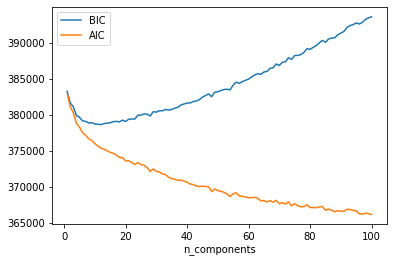

In [306]:
n_components = np.arange(1, 101)
models = [GaussianMixture(n, covariance_type='spherical', random_state=0).fit(df[range(50)]) for n in n_components]
plt.plot(n_components, [m.bic(df[range(50)]) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df[range(50)]) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

i guess the optimal number is like 17 for the English dataset

for the semantic shift dataset, looks like GMM is just ... not the way to go.

### stupid testing gaussian models because it's not working how i expect it to

nope, it's working how its designed. the problem is that the means are too far apart. maybe i should be doing this on less data?

In [61]:
test_data = np.asarray([[-3, -2, -2, -1, -1, 0, 0, 1]]).reshape(-1, 1)

n_components = 2
estimator = GaussianMixture(n_components=n_components, covariance_type='full', init_params='kmeans', max_iter=20) # other covariance is "spherical", "diag", "tied"
estimator.fit(test_data)

GaussianMixture(max_iter=20, n_components=2)

In [63]:
estimator.means_

array([[-0.28645026],
       [-2.30452965]])

In [62]:
estimator.predict_proba(np.asarray([[-3, -2, -2, -1, -1, 0, 0, 1]]).reshape(-1, 1))

array([[1.52466685e-02, 9.84753331e-01],
       [1.51009732e-01, 8.48990268e-01],
       [1.51009732e-01, 8.48990268e-01],
       [9.33645094e-01, 6.63549060e-02],
       [9.33645094e-01, 6.63549060e-02],
       [9.99869540e-01, 1.30459637e-04],
       [9.99869540e-01, 1.30459637e-04],
       [9.99999965e-01, 3.47874496e-08]])

(array([4., 0., 0., 0., 0., 0., 0., 0., 0., 4.]),
 array([-101. ,  -90.8,  -80.6,  -70.4,  -60.2,  -50. ,  -39.8,  -29.6,
         -19.4,   -9.2,    1. ]),
 <a list of 10 Patch objects>)

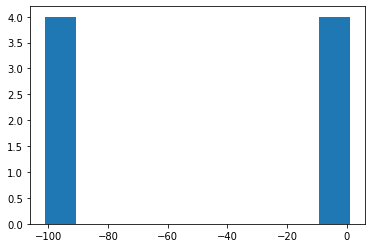

In [59]:
plt.hist(np.asarray([[-101, -100, -100, -99, -1, 0, 0, 1]]).reshape(-1, 1))

### what if we treated the cosine similarity to each of the clusters as vectors? 

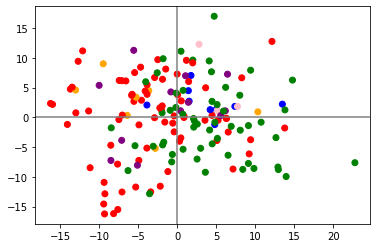

In [175]:
colors = {'metaphor':'red', 'metonymy': 'red', 'analogy': 'pink','antonymy': 'pink','narrowing':'blue', 'pejoration':'green', 'broadening':'purple', 'amelioration': 'orange', 'broadening, metaphor': 'red', 'pejoration, homophony':'green'}
plt.scatter(df[0], df[1], c=df.type.map(colors))
plt.axhline(y=0, color='grey')
plt.axvline(x=0, color='grey')

In [320]:
# source 7 is ['bacterial', 'bass', 'tropical', 'marine', 'grazing']
# source 9 is ['bodily', 'physical', 'mental', 'human', 'athletic']
colors = {'metaphor':'red', 'metonymy': 'pink', 'analogy': 'coral','antonymy': 'pink','narrowing':'blue', 'pejoration':'green', 'broadening':'purple', 'amelioration': 'orange', 'broadening, metaphor': 'red', 'pejoration, homophony':'green'}
plt.scatter(df['sim_7'], df['sim_9'], c=df.type.map(colors))
plt.axhline(y=0, color='grey')
plt.axvline(x=0, color='grey')

AttributeError: ignored

## labelling clusters 

seems like this labelling method works pretty well for detecting the target, but doesn't take source into account. which, sure

i'll try taking the negative vector and see if it'll give us more source information

actually, i've changed my mind. this ... does not work that well 

In [112]:
# get list of adjectives from frequency database because why not

freqDF = pd.read_csv('/content/drive/MyDrive/ColabFiles/COCA_freqs.csv', encoding='ISO-8859-1') # w1, coca_spok
adjectives = list(freqDF[(freqDF['c1']=='jj') & (freqDF['BNC']>500)]['w1'])

In [113]:
# embed in the model

adj_embeddings = model.encode(adjectives, convert_to_tensor=True)

In [254]:
# find closest adjectives to the estimator.mean

top_k = 5

def toTensor(arr):
  return torch.tensor(arr, dtype = torch.float32) #Function to easily convert arrays to tensors

source_words = []
target_words = []

for i in range(len(estimator.means_)):
    # target
    targets = []

    query_embedding = toTensor(estimator.means_[i])

    cos_scores = util.cos_sim(query_embedding, toTensor(pca.transform(adj_embeddings)))[0]
    top_results = torch.topk(cos_scores, k=top_k)

    for score, idx in zip(top_results[0], top_results[1]):
      targets.append(adjectives[idx])

    # source
    sources = []

    query_embedding = -toTensor(estimator.means_[i])

    cos_scores = util.cos_sim(query_embedding, toTensor(pca.transform(adj_embeddings)))[0]
    top_results = torch.topk(cos_scores, k=top_k)

    for score, idx in zip(top_results[0], top_results[1]):
      sources.append(adjectives[idx])
    
    source_words.append(sources)
    target_words.append(targets)

## spectral clustering

In [230]:
n_components=3
estimator = SpectralClustering(n_clusters=n_components, n_neighbors=20)
#estimator = SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                  #  eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                  #  kernel_params=None, n_clusters=4, n_components=None,
                  #  n_init=10, n_jobs=None, n_neighbors=10, random_state=None)
estimator.fit(df[range(50)])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


SpectralClustering(n_clusters=3, n_neighbors=20)

In [231]:
sc = estimator

In [233]:
sc

SpectralClustering(n_clusters=3, n_neighbors=20)

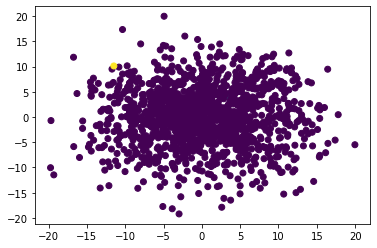

In [232]:
labels = sc.labels_

plt.scatter(df[0], df[1], c=labels)

In [67]:
estimator.affinity_matrix_

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## hierarchical clustering

this by definition isn't really going to do what i want

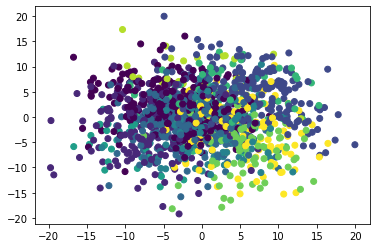

In [220]:
from sklearn.cluster import AgglomerativeClustering

hierarchical_cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(df[range(50)])
df['hc_labels'] = labels

plt.scatter(df[0], df[1], c=labels)

In [227]:
df[df['hc_labels']==9]

,meaning1,meaning2,0,1,2,3,4,5,6,7,...,41,42,43,44,45,46,47,48,49,hc_labels
48,belly,pregnant,4.665302,-0.703230,-7.134745,-1.070331,-2.044919,1.973140,-5.648613,-4.890226,...,3.802855,-1.938004,1.919409,0.452242,0.695957,-0.281494,2.055289,0.072335,2.125789,9
58,bile or gall,poison,4.412017,0.282970,-1.320659,5.973210,0.834781,-1.254345,-0.437799,4.698436,...,-1.741402,-0.328132,1.111736,0.787831,-1.399307,-1.571851,1.116176,0.451827,2.588133,9
61,bitter,beautiful,-1.548550,-2.740208,-4.118674,-0.856787,-6.710747,-1.050536,0.893913,-1.365716,...,1.237097,-0.272441,-2.086454,-0.413030,0.562135,0.205054,-1.485133,-0.252283,2.300634,9
77,blunt,stupid,8.296389,-6.048545,-5.002963,1.537802,-2.758916,-2.812801,-0.882323,6.014549,...,2.580077,-1.257603,2.887481,-0.261783,0.082981,0.399048,0.303967,-2.336540,-1.468889,9
94,box or container,coffin,11.620529,-7.383018,5.724882,7.734030,4.761868,4.316959,2.757238,3.031968,...,0.243993,1.489839,-0.687961,0.211097,-1.237585,1.040055,0.699940,1.254986,1.782302,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,to whet,to improve,0.696128,3.733258,-2.693331,2.868769,-3.683708,8.627599,4.153052,6.849176,...,1.809576,-1.393743,0.171988,1.941958,3.737285,-2.218717,-0.348700,-5.269293,-1.586532,9
1395,unripe fruit,young,9.026115,7.020052,0.316885,5.748744,-4.184964,5.827412,-2.081320,0.293678,...,2.254896,1.155036,-0.187461,-3.254208,-2.893957,0.158813,-2.934641,-1.044946,-1.545630,9
1415,wet,weak,8.231064,2.595587,-1.628860,1.228800,5.768327,4.974623,-4.319417,2.997116,...,-2.238350,-0.345708,0.522796,-1.221003,-0.324467,-2.214281,1.734233,0.686054,0.661352,9
1416,wheel,vehicle,-0.132635,0.582698,-2.947836,-2.639689,-1.682811,3.959294,-4.155992,-3.931115,...,-2.714323,-3.205106,1.102718,0.901495,2.532094,-3.546826,-0.044427,0.344335,-0.053197,9
